In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from matplotlib import colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

cmap = colors.LinearSegmentedColormap(
    "red_blue_classes",
    {
        "red": [(0, 1, 1), (1, 0.7, 0.7)],
        "green": [(0, 0.7, 0.7), (1, 0.7, 0.7)],
        "blue": [(0, 0.7, 0.7), (1, 1, 1)],
    },
)
plt.cm.register_cmap(cmap=cmap)


In [2]:
data = pd.read_csv('wdbc.data', header=None)


In [3]:
print(data.shape)
data.head()


(569, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Avant de commencer le traitement des donnés on fait le changement de la colonne 1 avec B = 0 et M = 1 

In [4]:
def change_c1(x):
    if x == 'M':
        return 1
    else:
        return 0


data[1] = data[1].apply(change_c1)


# Exercice 1

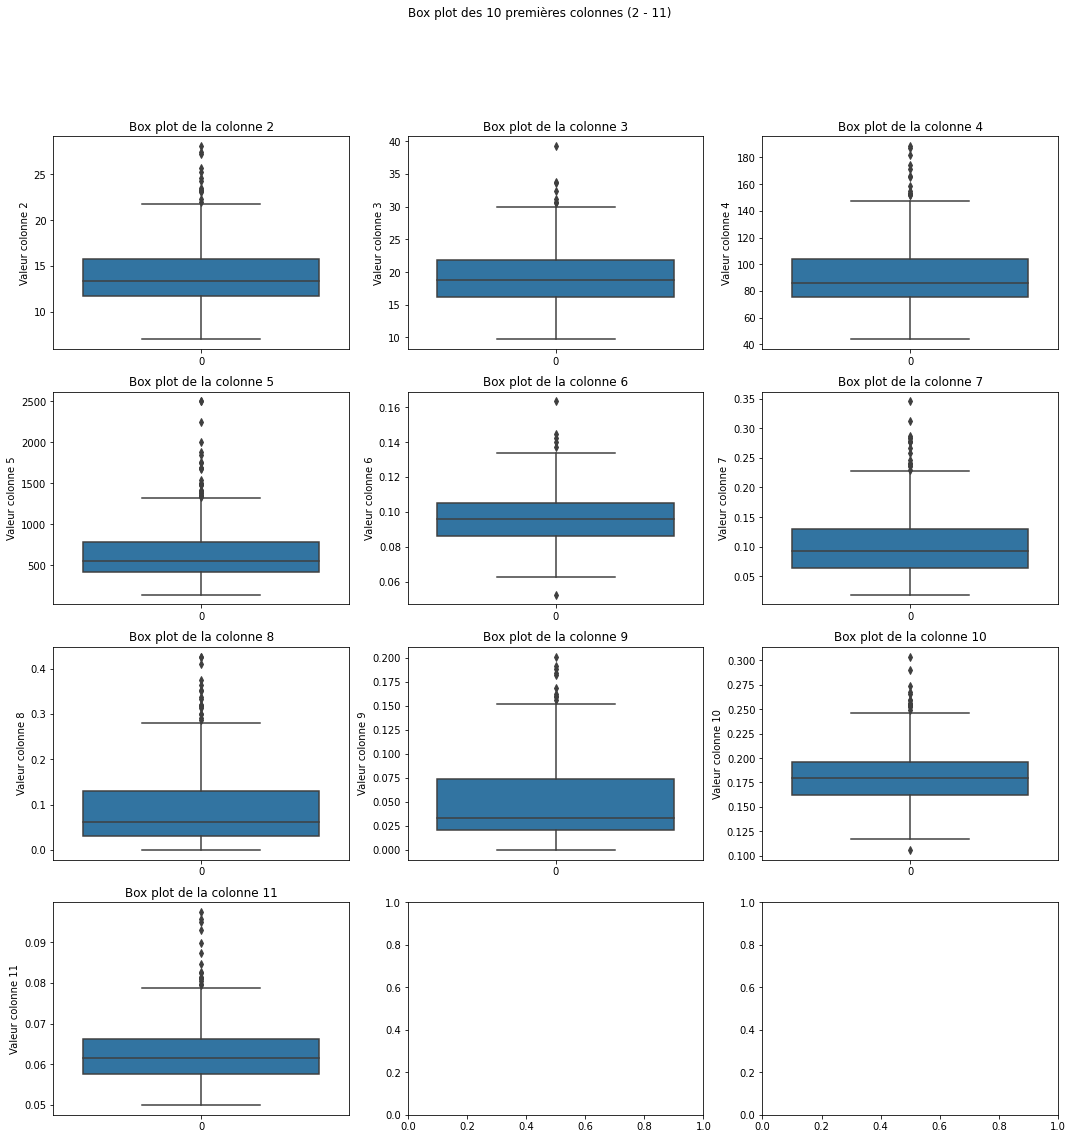

In [5]:
fig, axes = plt.subplots(4, 3, figsize=(18, 18))

fig.suptitle('Box plot des 10 premières colonnes (2 - 11)')

for i in range(4):
    for j in range(3):
        n = 2+i*3+j
        if (n - 2 < 10):
            sns.boxplot(ax=axes[i, j], data=data[n]).set(
                title=f'Box plot de la colonne {n}', ylabel=f'Valeur colonne {n}')


Le nombre d'outliers au-dessus des bornes du graphe est supérieur qu’au-dessous. 

# Exercice 2

<AxesSubplot: >

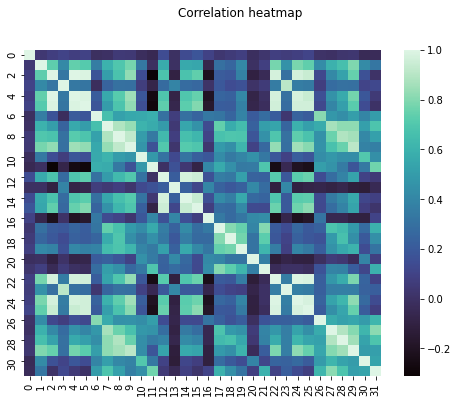

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle('Correlation heatmap')
sns.heatmap(ax=ax, data=data.corr(), cmap='mako')


# Exercice 3

On observe que:

- Forte correlation entre les colonnes 2, 4 et 5.
- Correlation relativement forte entre la colonne d'intérêt 1 et plusieurs autres colonnes. 
- La colonne 0 n'a quasiment aucune correlation avec les autres variables. Il 
- Les colonnes 2, 4, 5, 22, 24, 25 n'ont quasiment aucune correlation avec les colonnes 11 et 16. 

# Traitement des données avant l'exercice 4

## Centralisation et normalisation par l'écart type.

In [7]:
data2 = data.copy()
data2.loc[:, 2:31] = data2.loc[:, 2:31] - data2.loc[:, 2:31].mean()
data2.loc[:, 2:31] = data2.loc[:, 2:31].divide(data2.loc[:, 2:31].std())

data2.loc[:, 0] = data2.loc[:, 0] - data2.loc[:, 0].mean()
data2.loc[:, 0] = data2.loc[:, 0].divide(data2.loc[:, 0].std())

#
print('Écart type des colonnes 2 à 6 : \n')
print(data2.loc[:, 2:31].std().head())
print('\n')
print('Moyenne des colonnes 2 à 6 : \n')
print(data2.loc[:, 2:31].mean().head())


Écart type des colonnes 2 à 6 : 

2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
dtype: float64


Moyenne des colonnes 2 à 6 : 

2   -3.181989e-15
3   -6.579388e-15
4   -7.012551e-16
5   -8.608619e-16
6    6.027594e-15
dtype: float64


## ACP

In [8]:
correlation_matrix = data2.corr().to_numpy()
eig_vals, eig_vecs = np.linalg.eig(correlation_matrix)

eig_vals_sorted = np.sort(eig_vals)
eig_vecs_sorted = eig_vecs[:, eig_vals.argsort()]
# To select eigenvectur do eig_vals_sorted[:,i] where i is the eigenvector for eigenvalue index i


In [9]:
selected_eig_vals = eig_vals_sorted[-3:]
selected_eig_vecs = eig_vecs_sorted[:, -3:]

A = selected_eig_vecs.copy()

print(f"Dimension de la matrice A = {A.shape}")


Dimension de la matrice A = (32, 3)


In [10]:
eig_vals_sorted


array([1.32627484e-04, 7.41166366e-04, 1.58846587e-03, 6.86680063e-03,
       8.05020965e-03, 1.54720775e-02, 1.75344105e-02, 2.41885291e-02,
       2.73324121e-02, 2.94706061e-02, 3.06710366e-02, 4.79306346e-02,
       5.14522733e-02, 5.87826404e-02, 7.98097711e-02, 8.80445608e-02,
       1.48555118e-01, 2.11612257e-01, 2.61003650e-01, 2.90848295e-01,
       3.03566601e-01, 3.49167750e-01, 4.04138074e-01, 4.69725710e-01,
       6.81174904e-01, 9.78906796e-01, 1.23470274e+00, 1.65913439e+00,
       1.99913213e+00, 2.86492379e+00, 5.73130664e+00, 1.39240329e+01])

In [11]:
selected_eig_vals


array([ 2.86492379,  5.73130664, 13.92403293])

In [12]:
X_prime = pd.DataFrame(((A.T).dot(data2.T)).T)
# np.matmul(A.T,data2.loc[0,:])
print(X_prime.shape)
X_prime.head()


(569, 3)


,0,1,2
0,-0.964783,2.157715,-9.144322
1,-0.522825,-3.744582,-2.584614
2,-0.436424,-0.987184,-5.831210
3,-3.222958,10.329411,-7.066802
4,1.494998,-1.892362,-4.071325


# Exercice 4

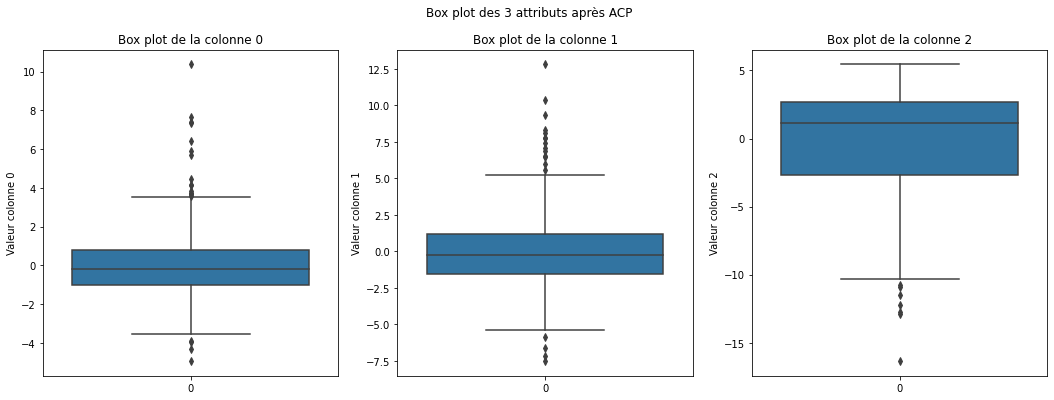

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

fig.suptitle('Box plot des 3 attributs après ACP')

for i in range(3):
    sns.boxplot(ax=axes[i], data=X_prime[i]).set(
        title=f'Box plot de la colonne {i}', ylabel=f'Valeur colonne {i}')


# Exercice 5

<AxesSubplot: >

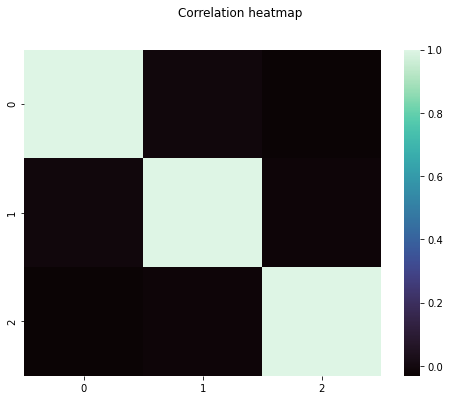

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle('Correlation heatmap')
sns.heatmap(ax=ax, data=X_prime.corr(), cmap='mako')


# Exercice 6

Text(0.5, 0.92, "Scatter plot de la varaible d'intérêt en fonction des attributs après ACP")

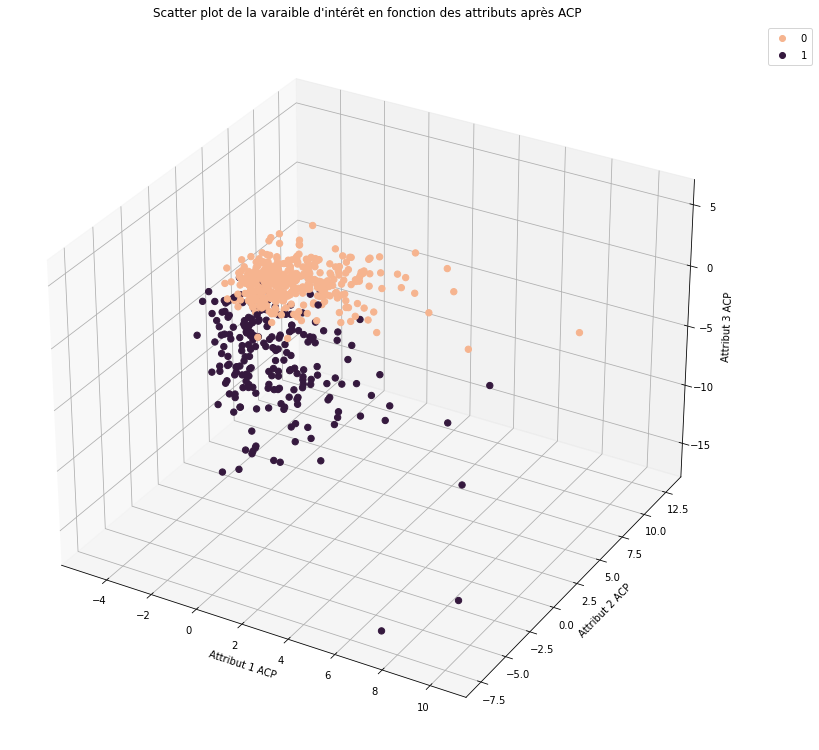

In [15]:
# 3D Plot

x = X_prime[0]
y = X_prime[1]
z = X_prime[2]

# axes instance
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
# sns.color_palette("husl", 256).as_hex()
cmap = ListedColormap(sns.color_palette("rocket_r"))

# plot
sc = ax.scatter(x, y, z, s=40, c=data[1], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('Attribut 1 ACP')
ax.set_ylabel('Attribut 2 ACP')
ax.set_zlabel('Attribut 3 ACP')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("Scatter plot de la varaible d'intérêt en fonction des attributs après ACP")

# save
#plt.savefig("scatter_hue", bbox_inches='tight')


# Exercice 7

Text(0.5, 1.0, "Scatter plot de la varaible d'intérêt en fonction des attributs 1 et 2 après ACP")

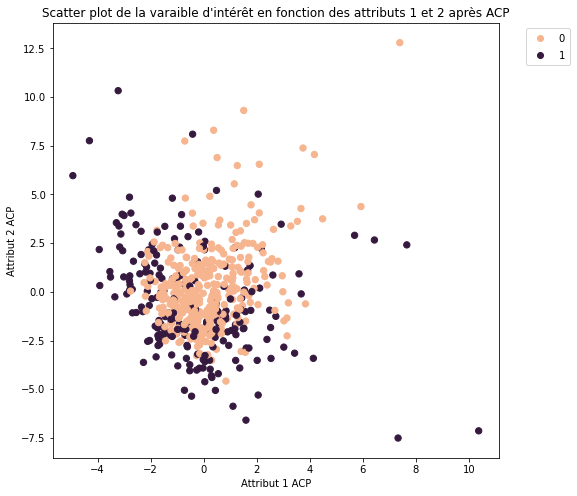

In [16]:
x = X_prime[0]
y = X_prime[1]

fig, ax = plt.subplots(figsize=(8, 8))

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("rocket_r"))

# plot
sc = ax.scatter(x, y, s=40, c=data[1], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('Attribut 1 ACP')
ax.set_ylabel('Attribut 2 ACP')

plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title(
    "Scatter plot de la varaible d'intérêt en fonction des attributs 1 et 2 après ACP")


Text(0.5, 1.0, "Scatter plot de la varaible d'intérêt en fonction des attributs 1 et 3 après ACP")

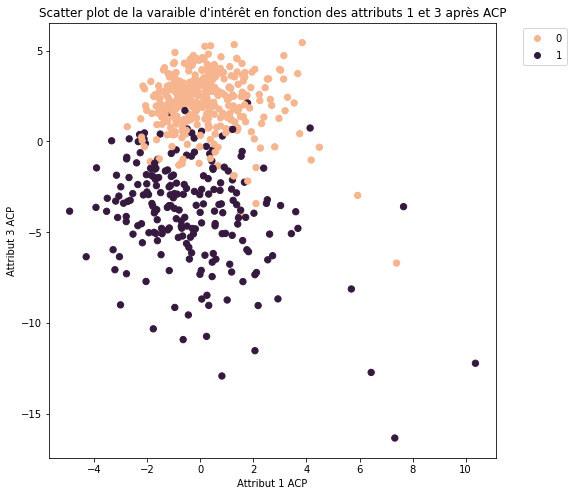

In [17]:
x = X_prime[0]
y = X_prime[2]

fig, ax = plt.subplots(figsize=(8, 8))

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("rocket_r"))

# plot
sc = ax.scatter(x, y, s=40, c=data[1], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('Attribut 1 ACP')
ax.set_ylabel('Attribut 3 ACP')

plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title(
    "Scatter plot de la varaible d'intérêt en fonction des attributs 1 et 3 après ACP")


Text(0.5, 1.0, "Scatter plot de la varaible d'intérêt en fonction des attributs 2 et 3 après ACP")

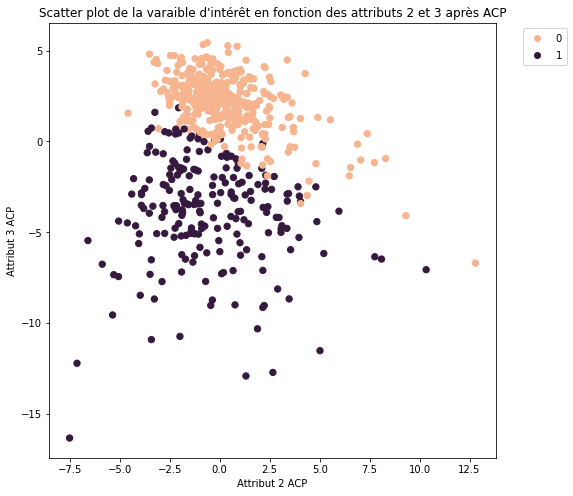

In [18]:
x = X_prime[1]
y = X_prime[2]

fig, ax = plt.subplots(figsize=(8, 8))

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("rocket_r"))

# plot
sc = ax.scatter(x, y, s=40, c=data[1], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('Attribut 2 ACP')
ax.set_ylabel('Attribut 3 ACP')

plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title(
    "Scatter plot de la varaible d'intérêt en fonction des attributs 2 et 3 après ACP")


In [19]:
X_prime.corr()


,0,1,2
0,1.000000,-0.008357,-0.031052
1,-0.008357,1.000000,-0.018981
2,-0.031052,-0.018981,1.000000


In [20]:
X_primeprime = X_prime.copy()


In [21]:
X_primeprime['Y'] = data[1]


In [22]:
X_primeprime.corr()  # baixa correlacoa com Y


,0,1,2,Y
0,1.000000,-0.008357,-0.031052,-0.145852
1,-0.008357,1.000000,-0.018981,-0.168309
2,-0.031052,-0.018981,1.000000,-0.798376
Y,-0.145852,-0.168309,-0.798376,1.000000


# Exercice 8, 9, 10 et 11

Obs : Le code du plot a été addapté de https://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html#sphx-glr-auto-examples-classification-plot-lda-qda-py

In [23]:
from scipy import linalg


def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title("Linear Discriminant Analysis")
        #plt.ylabel("Data with\n fixed covariance")
    elif fig_index == 2:
        plt.title("Quadratic Discriminant Analysis")
    # elif fig_index == 3:
    #    plt.ylabel("Data with\n varying covariances")

    tp = y == y_pred  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker=".", color="red")
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker="x",
                s=20, color="#990000")  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker=".", color="blue")
    plt.scatter(
        X1_fp[:, 0], X1_fp[:, 1], marker="x", s=20, color="#000099"
    )  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(
        xx, yy, Z, cmap="red_blue_classes", norm=colors.Normalize(0.0, 1.0), zorder=0
    )
    plt.contour(xx, yy, Z, [0.5], linewidths=2.0, colors="white")

    # means
    plt.plot(
        lda.means_[0][0],
        lda.means_[0][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )
    plt.plot(
        lda.means_[1][0],
        lda.means_[1][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(
        mean,
        2 * v[0] ** 0.5,
        2 * v[1] ** 0.5,
        180 + angle,
        facecolor=color,
        edgecolor="black",
        linewidth=2,
    )
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, "red")
    plot_ellipse(splot, lda.means_[1], lda.covariance_, "blue")


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariance_[0], "red")
    plot_ellipse(splot, qda.means_[1], qda.covariance_[1], "blue")


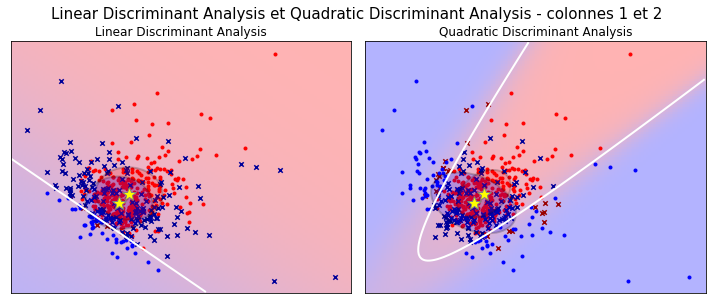

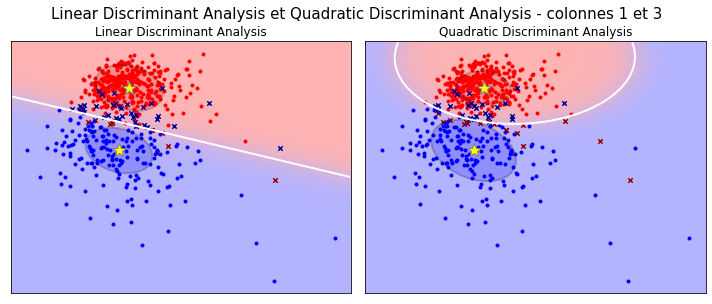

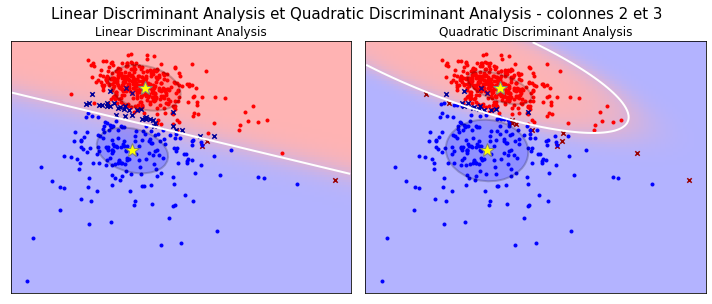

In [24]:
import warnings
list_plots = [[0, 1], [0, 2], [1, 2]]
warnings.filterwarnings("ignore")

for columns_ACP in list_plots:
    plt.figure(figsize=(10, 8), facecolor="white")
    plt.suptitle(
        f"Linear Discriminant Analysis et Quadratic Discriminant Analysis - colonnes {columns_ACP[0] + 1} et {columns_ACP[1] + 1}",
        y=0.98,
        fontsize=15,
    )

    # LDA
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    X = X_prime.loc[:, columns_ACP].to_numpy()
    y = data[1]
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=1)
    plot_lda_cov(lda, splot)  # Ellipse
    plt.axis("tight")

    # QDA
    qda = QuadraticDiscriminantAnalysis(store_covariance=True)
    X = X_prime.loc[:, columns_ACP].to_numpy()
    y = data[1]
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2)
    plot_qda_cov(qda, splot)  # Ellipse
    plt.axis("tight")

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


On remarque que les LDA et QDA sur les donnés sont obtenues dans chaque y_pred = lda.fit(X,y).predict(X) ou y_pred = qda.fit(X,y).predict(X)

# Exercice 12

In [25]:
def compute_values(y_pred, y_test):

    vrai_pos = 0
    faux_pos = 0

    vrai_neg = 0
    faux_neg = 0

    for i in range(len(y_pred)):
        if y_pred[i] == 1:
            if y_test[i] == 1:
                vrai_pos += 1
            else:
                faux_pos += 1
        else:
            if y_test[i] == 1:
                faux_neg += 1
            else:
                vrai_neg += 1

    return np.array([vrai_pos, faux_pos, vrai_neg, faux_neg])


In [30]:
X = X_prime.loc[:, [1, 2]]
y = data[1]
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits)
skf.get_n_splits(X, y)

values_kfold_lda = []
values_kfold_qda = []

for train_index, test_index in skf.split(X, y):

    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    y_test_np = y_test.to_numpy()

    y_pred_lda = lda.fit(X_train, y_train).predict(X_test)
    y_pred_qda = qda.fit(X_train, y_train).predict(X_test)

    values_kfold_lda.append(compute_values(y_pred_lda, y_test_np))
    values_kfold_qda.append(compute_values(y_pred_qda, y_test_np))

values_kfold_lda = np.array(values_kfold_lda)
values_kfold_qda = np.array(values_kfold_qda)


In [35]:
lda_accuracy = values_kfold_lda.sum(axis=0)
print(lda_accuracy)


[176   3 354  36]


In [36]:
qda_accuracy = values_kfold_qda.sum(axis=0)
print(qda_accuracy)


[197  12 345  15]


In [48]:
print(
    f"Précision du modèle LDA : {100 * (lda_accuracy[0] + lda_accuracy[2]) / lda_accuracy.sum() :.1f} %")
print(
    f"Précision du modèle QDA : {100 * (qda_accuracy[0] + qda_accuracy[2]) / qda_accuracy.sum() :.1f} %")


Précision du modèle LDA : 93.1 %
Précision du modèle QDA : 95.3 %


In [50]:
print(
    f"Précision du modèle LDA : {100 * lda_accuracy[0] / (lda_accuracy[0] + lda_accuracy[1]) :.1f} %")
print(
    f"Précision du modèle QDA : {100 * qda_accuracy[0] / (qda_accuracy[0] + qda_accuracy[1]) :.1f} %")


Précision du modèle LDA : 98.3 %
Précision du modèle QDA : 94.3 %


# Exercice 13

[Text(0.5, 1.0, 'Matrice de Confusion - LDA')]

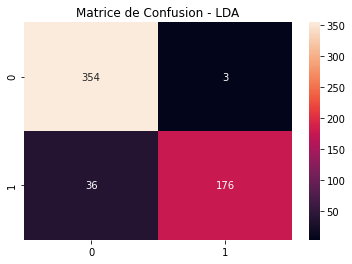

In [69]:
sns.heatmap(lda_accuracy[[2, 1, 3, 0]].reshape(
    (2, 2)), annot=True, fmt='g').set(title="Matrice de Confusion - LDA")


[Text(0.5, 1.0, 'Matrice de Confusion - QDA')]

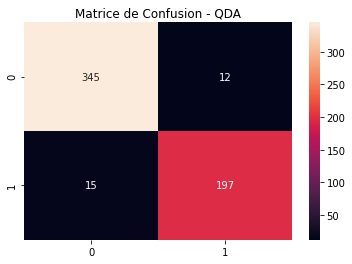

In [70]:
sns.heatmap(qda_accuracy[[2, 1, 3, 0]].reshape(
    (2, 2)), annot=True, fmt='g').set(title="Matrice de Confusion - QDA")


# Conclusion
Les valeurs de rappel de précision obtenues montrent que le modèle développé prévoit avec justesse l’existence de cancer. On remarque à travers la validation croisée que le nombre de faux positifs et négatifs est largement inférieur au nombre de bonnes prédictions pour les deux modèles. En revanche, le modèle QDA montre un nombre plus important de faux négatifs qui, dans le cadre de la détection d’un cancer, est une erreur plus grave qu’un faux positif.